In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read in results
df = pd.read_csv('results/trans_results.csv')
perf_df = pd.read_csv('results/perfs.csv')
session_mats = pd.read_csv("results/session_markovs.csv", index_col=0)

In [3]:
# list of labels/markov state names
states = ["s", "d", "b", "f", "q"]
state_names = [s[0].upper() for s in states]

In [ ]:
# list of all sessions (ignores MAG)
all_sessions = df['session'].unique()
# filter out MAG
all_sessions = all_sessions[all_sessions < 10000]
all_sessions

array([15203])

In [5]:
# labels each possible transition
trans_names = []
[[trans_names.append(ii+jj) for ii in state_names] for jj in state_names]

# auxillary method to name each possible transition
def label_expand(i):
    reg = np.zeros((1,25))
    reg[:,i] = 1
    reg_df = pd.DataFrame(reg.tolist(), columns=trans_names)
    return reg_df

rr = df['labels'].map(label_expand)
regression_df = pd.concat(rr.tolist())
regression_df['perf'] = df['session']

# try to 
for ii in all_sessions:
    try:
        s = df['perf'][df['session'].iloc[ii]]
        regression_df['perf'].iloc[ii] = s
    except:
        regression_df['perf'].iloc[ii] = np.nan

regression_df = regression_df.dropna()

In [ ]:
# associates each session with its performance
perfs = []
for s in all_sessions:
    if(s in perf_df["mission"].tolist()):
        p = [perf_df[perf_df['mission'] == s]['perf']][0].tolist()
        perfs = perfs + p
perfs = np.array(perfs)
session_mats['perfs'] = perfs

In [ ]:
from sklearn.linear_model import LinearRegression 
import scipy.stats

# creates a linear regression between the probability of each of the 25 possible transitions for each session and session performance
model=LinearRegression()
X = session_mats[trans_names]
Y = session_mats['perfs']
model.fit(X,Y)

# store the r squared value and the coefficients
r_sq = model.score(X,Y)
nums = model.coef_.copy()

# calculate z scores for each of the coefficients
dist = scipy.stats.norm(nums.mean(), nums.std())
# calculate the p-values for each of the coefficients
probs = [dist.cdf(n) for n in nums]

# format and save the significance of each of the coefficients
sig_df = pd.DataFrame(np.array(probs).reshape(1,25), columns=trans_names)
sig_df.to_csv("results/linear_reg_sig.csv")

,SS,DS,BS,FS,QS,SD,DD,BD,FD,QD,...,SF,DF,BF,FF,QF,SQ,DQ,BQ,FQ,QQ
0,0.414329,0.486528,0.367486,0.928926,0.319681,0.186211,0.483513,0.527367,0.524662,0.284816,...,0.284292,0.497128,0.541837,0.499371,0.078318,0.298406,0.765068,0.521482,0.99998,0.487483


[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'coeffs')]

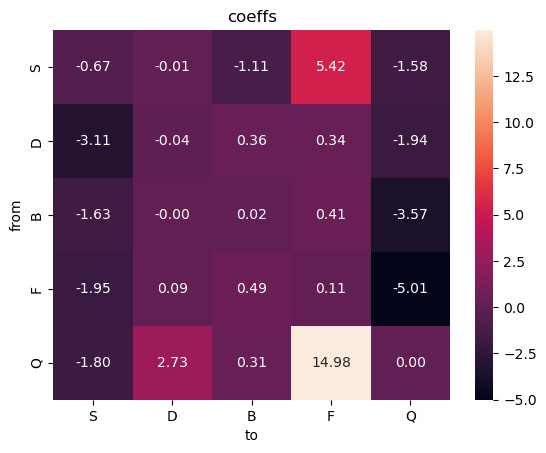

In [ ]:
# plot linear regression coefficient values
coeffs = nums.reshape(5,5)
hm = sns.heatmap(coeffs, fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to',title='coeffs')

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'p-val')]

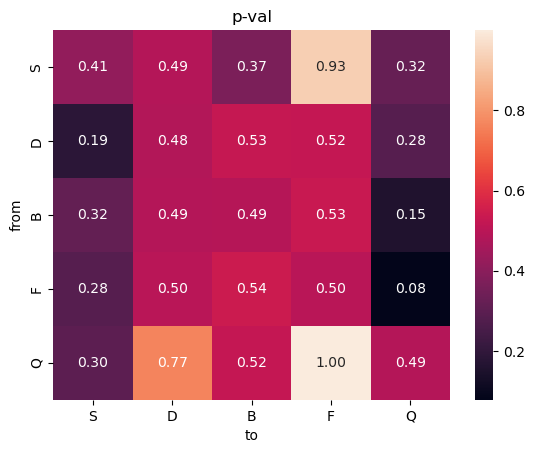

In [ ]:
# plot linear regression coefficient pvalues
hm = sns.heatmap(np.array(probs).reshape(5,5), fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to',title='p-val')

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'coeffs (p-val < 0.05)')]

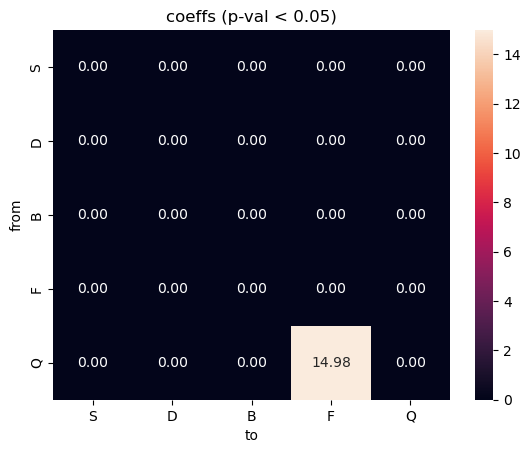

In [ ]:
# plot only segnificant coefficients (p < .05)
sig_coeffs = coeffs.copy()
sig_coeffs[np.array(probs).reshape(5,5) < 1 - 0.05] = 0
hm = sns.heatmap(sig_coeffs, fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to',title='coeffs (p-val < 0.05)')